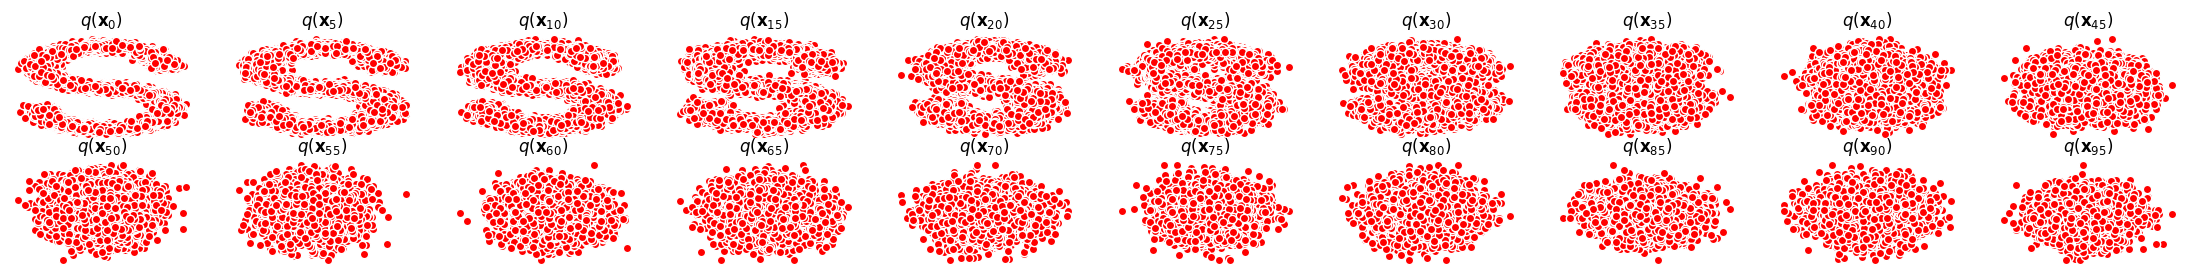

In [9]:
import numpy as np
import torch
import torch.nn as nn
import random
import os

from sklearn.datasets import make_s_curve
import matplotlib.pyplot as plt

from models.ddpm.net import MLPDiffusion
from infras.misc import cprint


device = torch.device('cpu')
# device = torch.device('mps')

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


class DDPM(nn.Module):

    def __init__(
        self,
        s_dim,
        diff_steps,
        beta_min=1e-5,
        beta_max=5e-3,
        hidden_dim=128,
        hidden_layers=3,
    ):
        super().__init__()

        self.s_dim = s_dim
        self.diff_steps = diff_steps

        self.noise_net = MLPDiffusion(
            s_dim=self.s_dim,
            hidden_dim=hidden_dim,
            hidden_layers=hidden_layers,
            n_steps=self.diff_steps,
        )

        betas = torch.linspace(-10,10,self.diff_steps)
        betas = torch.sigmoid(betas)*(beta_max-beta_min)+beta_min
        alphas = 1.0 - betas

        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)
        self.register_buffer('alphas_bar', torch.cumprod(alphas,0))
        self.register_buffer('alphas_bar_sqrt', torch.sqrt(torch.cumprod(alphas,0)))
        self.register_buffer('one_minus_alphas_bar_sqrt', torch.sqrt(1.0-torch.cumprod(alphas,0)))

        self.register_buffer('dummy', torch.tensor([]))

    def forward_diffusion(self, x0, t):
        epsilon = torch.randn_like(x0).to(self.dummy.device)
        c_mean = self.alphas_bar_sqrt[t]
        c_std = self.one_minus_alphas_bar_sqrt[t]
        xt = x0*c_mean + epsilon*c_std   # reparam trick
        return xt

    def eval_noise_loss(self, x0):

        batch_size = x0.shape[0]

        t = torch.randint(0,self.diff_steps,size=(batch_size//2,))
        t = torch.cat([t,self.diff_steps-1-t],dim=0)

        coeff_x0 = self.alphas_bar_sqrt[t].reshape([-1,1])
        coeff_epsi = self.one_minus_alphas_bar_sqrt[t].reshape([-1,1])

        epsi = torch.randn_like(x0).to(self.dummy.device)
        x = x0*coeff_x0 + coeff_epsi*epsi

        pred = self.noise_net(x, t)
        err_noise = (epsi - pred).square().mean()

        return err_noise



model = DDPM(
    s_dim=2,
    diff_steps=100,
).to(device)

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print (name, param.data.shape)

# print(model.one_minus_alphas_bar_sqrt)

s_curve, _ = make_s_curve(10000, noise=0.1)
s_curve_2d = s_curve[:, [0,2]]/10.0
#
#
dataset = torch.Tensor(s_curve_2d).float().to(device)
#
#

# batch_size = 128
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)
#
# # model = MLPDiffusion(num_steps)#输出维度是2，输入是x和step
# # optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
#
# idx, batch_x = next(enumerate(dataloader))
#
# model.eval_noise_loss(batch_x)

num_shows = 20
fig,axs = plt.subplots(2,10,figsize=(28,3))
plt.rc('text',color='black')

for i in range(num_shows):
    j = i//10
    k = i%10
    q_i = model.forward_diffusion(dataset,torch.tensor([i*model.diff_steps//num_shows]))#生成t时刻的采样数据
    axs[j,k].scatter(q_i[:,0],q_i[:,1],color='red',edgecolor='white')
    axs[j,k].set_axis_off()
    axs[j,k].set_title('$q(\mathbf{x}_{'+str(i*model.diff_steps//num_shows)+'})$')

